In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [76]:
import numpy as np
import pandas as pd

In [77]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [79]:
engine = create_engine("sqlite:///Resources/hawaii1.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [81]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [83]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [84]:
# Use the Inspector to explore the database and print the table names
from sqlalchemy import create_engine, inspect, func
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [85]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [86]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [87]:
# Dates Max and Min
print("Number of fields with date: ",session.query(func.count(Measurement.date)).all())
print("Latest date: ",session.query(func.max(Measurement.date)).all()[0][0])
print("Earliest date: ",session.query(func.min(Measurement.date)).all()[0][0])

session.query(func.min(Measurement.date)).all()

Number of fields with date:  [(19550,)]
Latest date:  2017-08-23
Earliest date:  2010-01-01


[('2010-01-01')]

In [88]:
# Earliest Date
print("Earliest date: ",session.query(Measurement.date).order_by(Measurement.date).first()[0])
# Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print("Latest Date: ",latest_date)

Earliest date:  2010-01-01
Latest Date:  2017-08-23


In [89]:
l_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = l_date - dt.timedelta(days=365)
print (one_year_ago)

2016-08-23 00:00:00


In [90]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all())
# Sort the dataframe by date
df1 = prec_df.sort_values(by=['date'])
df2 = df1.set_index('date').dropna()
df2.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


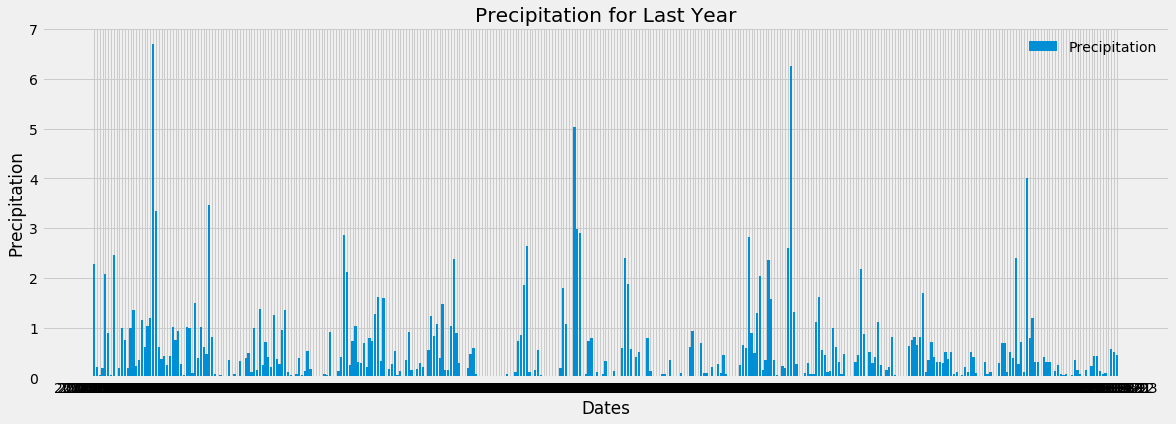

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(18,6))
plt.bar(df2.index.tolist(),df2["prcp"], label = 'Precipitation')
plt.title("Precipitation for Last Year")
plt.xlabel("Dates")
plt.legend(loc='best', frameon=False)
plt.ylabel("Precipitation")
plt.show()

In [92]:
#To check how many days of data in df2
df3 = df2.groupby(['date']).mean()
df3['prcp'].count()

365

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data

stats_df = pd.DataFrame(df2["prcp"].describe())
stats_df

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [94]:
# Design a query to show how many stations are available in this dataset?
print ("Number of stations: ", session.query(func.count(Station.id)).all()[0][0])


Number of stations:  9


In [95]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

from sqlalchemy import desc
session.query(Measurement.station, func.count(Measurement.station).label('N_rows')).\
          group_by(Measurement.station).order_by(desc('N_rows')).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [96]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [97]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

df_active = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281',Measurement.date >= one_year_ago).all())

df_active.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


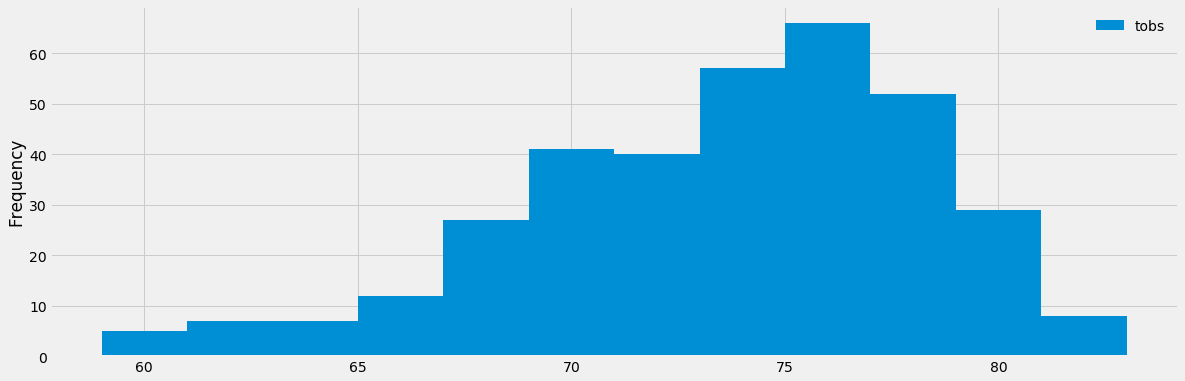

In [98]:
plt.figure(figsize=(18,6))
plt.hist(df_active['tobs'], bins=12, label = 'tobs')
plt.ylabel('Frequency')
plt.legend(loc='best', frameon=False)
plt.show()

In [99]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [100]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

delta = 234
prev_start = dt.date(2017, 8 ,23) - dt.timedelta(days=delta)
prev_end = dt.date(2017, 8 ,23) - dt.timedelta(days=delta-6)
print("Start Date: ",prev_start)
print("End Date: ",prev_end)
info = calc_temps(prev_start, prev_end)
print (info)

Start Date:  2017-01-01
End Date:  2017-01-07
[(62.0, 68.36585365853658, 74.0)]


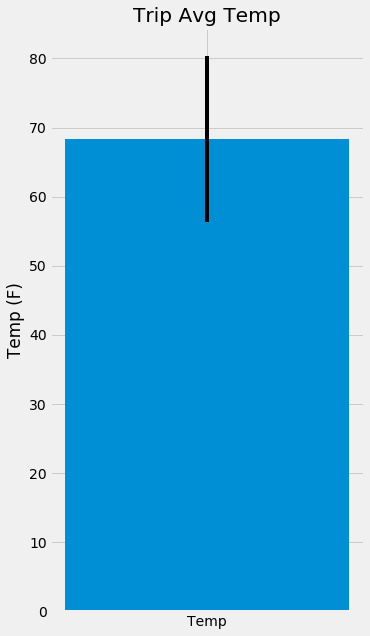

In [101]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

t = info[0][1]
max1 = info[0][2]
min1 = info[0][0]

plt.figure(figsize=(5,10))
plt.bar(['Temp'],[t],yerr=[max1-min1])
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.show()

In [125]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#delta = 234
#length = 3

delta = 233
length = 3

prev_start = dt.date(2017, 8 ,23) - dt.timedelta(days=delta)
prev_end = dt.date(2017, 8 ,23) - dt.timedelta(days=delta-length)

print("Start Date: ",prev_start)
print("End Date: ",prev_end)

df_stations = pd.DataFrame(session.query(Measurement.station, Station.name, Station.latitude, Station.longitude,
              Station.elevation, func.sum(Measurement.prcp).\
              label('prcp')).filter(Measurement.date >= prev_start).filter(Measurement.date <= prev_end).\
              group_by(Measurement.station).order_by(desc('prcp')).\
              join(Station, Station.station == Measurement.station ).all())
df_stations

Start Date:  2017-01-02
End Date:  2017-01-05


,station,name,latitude,longitude,elevation,prcp
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.60
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.47
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.07
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.01
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.00
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


## Optional Challenge Assignment

In [103]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [104]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start_d = "2018-01-01"
end_d = "2018-01-07"

# Use the start and end date to create a range of dates

start = dt.datetime.strptime(start_d, '%Y-%m-%d')
end = dt.datetime.strptime(end_d, '%Y-%m-%d')
step = dt.timedelta(days=1)

date_range = []
while start <= end:
    date_range.append(start.date())
    start += step

dates = []
for d in date_range:
    dates.append(d.strftime('%Y-%m-%d'))
    
# Stip off the year and save a list of %m-%d strings
date_str = []
for d in date_range:
    date_str.append(d.strftime('%m-%d'))

# Loop through the list of %m-%d strings and calculate the normals for each date

normals_list = []
for d in date_str:
    normals_list.append(daily_normals(d))

print (normals_list)

[[(62.0, 69.15384615384616, 77.0)], [(60.0, 69.39622641509433, 77.0)], [(62.0, 68.9090909090909, 77.0)], [(58.0, 70.0, 76.0)], [(56.0, 67.96428571428571, 76.0)], [(61.0, 68.96491228070175, 76.0)], [(57.0, 68.54385964912281, 76.0)]]


In [105]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tmin = []
tavg = []
tmax = []
for row in normals_list:
    tmin.append(row[0][0])
    tavg.append(row[0][1])
    tmax.append(row[0][2])

normals_df = pd.DataFrame({"date":dates, "tmin":tmin, "tavg":tavg, "tmax":tmax})
normals_df1 = normals_df.set_index('date')
normals_df1

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


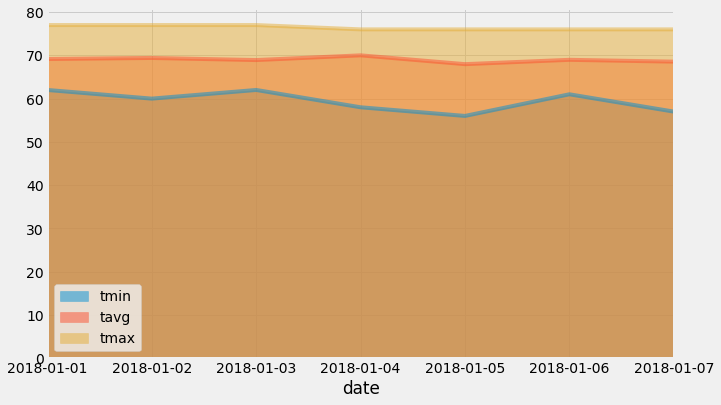

In [108]:
# Plot the daily normals as an area plot with `stacked=False`
#plt.figure(figsize=(10,4))
normals_df1.plot.area(stacked=False, figsize=(10,6))
#plt.show()